In [1]:
import time
from datetime import date
import pandas as pd
import os
import glob
import pycytominer
import sys
import CBE_utils as CBE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import correlation
import re
import gc

In [2]:
import importlib
importlib.reload(CBE)

<module 'CBE_utils' from '/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/notebooks/CBE_utils.py'>

In [3]:
input_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/new_output_files/"
output_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/new_result_files/"

annotation_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/annotation_files/"

In [4]:
# load normalized data
pattern = "[A-Z][0-9][0-9][0-9][0-9]_R[1-4]_mad_robustize.csv"
files = glob.glob(input_path + os.sep + '*' + os.sep + os.sep + '*' + os.sep + pattern, recursive=True)

# TODO: needs to change in the future
# TODO: process only what is not processed yet
Data = []

for file in files:
    
    filename = os.path.basename(file)
    
    try:
        
        Data_Temp = pd.read_csv(file)
        row_count = Data_Temp.shape[0]
        
        print(f"File: {filename} has {row_count} rows")
        
        Data.append(Data_Temp)
            
    except Exception as e:
        
        print(f"Error reading file {filename}: {e}")
        
        
### concat all files together
Data_aggregated = pd.concat(Data)
Data_aggregated = Data_aggregated.reset_index(drop = True)

print("Aggregated Data has shape ", Data_aggregated.shape)

File: C1231_R1_mad_robustize.csv has 384 rows
File: C1241_R1_mad_robustize.csv has 384 rows
File: C1230_R3_mad_robustize.csv has 384 rows
File: C1230_R4_mad_robustize.csv has 384 rows
File: C1231_R4_mad_robustize.csv has 384 rows
File: C1241_R2_mad_robustize.csv has 384 rows
File: C1230_R2_mad_robustize.csv has 384 rows
File: C1231_R2_mad_robustize.csv has 384 rows
File: C1241_R3_mad_robustize.csv has 384 rows
File: C1230_R1_mad_robustize.csv has 384 rows
File: C1231_R3_mad_robustize.csv has 384 rows
File: C1162_R4_mad_robustize.csv has 384 rows
File: C1175_R1_mad_robustize.csv has 384 rows
File: C1160_R2_mad_robustize.csv has 384 rows
File: C1160_R3_mad_robustize.csv has 384 rows
File: C1165_R2_mad_robustize.csv has 384 rows
File: C1176_R1_mad_robustize.csv has 384 rows
File: C1167_R1_mad_robustize.csv has 384 rows
File: C1166_R1_mad_robustize.csv has 384 rows
File: C1158_R4_mad_robustize.csv has 384 rows
File: C1158_R2_mad_robustize.csv has 384 rows
File: C1170_R1_mad_robustize.csv h

In [5]:
replicate_list = Data_aggregated['Metadata_plate_map_name'].unique()
replicate_dataframe = pd.DataFrame(replicate_list, columns=['Metadata_plate_map_name']) 

replicate_list_newcolumns = replicate_dataframe['Metadata_plate_map_name'].str.split('_', n=1, expand=True)
replicate_dataframe['Metadata_plate_name'] = replicate_list_newcolumns[0]
replicate_dataframe['Metadata_replicate_number'] = replicate_list_newcolumns[1]

replicate_counts = replicate_dataframe.groupby('Metadata_plate_name')['Metadata_replicate_number'].count().reset_index()

# Group by 'measurement_code' and filter groups that have exactly four replicates
filtered_replicate_dataframe= replicate_dataframe.groupby('Metadata_plate_name').filter(lambda x: len(x['Metadata_replicate_number']) == 4)
filtered_replicate_dataframe = filtered_replicate_dataframe.sort_values(by=['Metadata_plate_name'])

Data_aggregated_filtered = Data_aggregated[Data_aggregated['Metadata_plate_map_name'].isin(filtered_replicate_dataframe['Metadata_plate_map_name'])]

In [6]:
Data_aggregated_filtered.head()
print(Data_aggregated_filtered['Metadata_source'].unique())
print(Data_aggregated_filtered['Metadata_plate_name'].unique())

['IMTM' 'USC']
['C1231' 'C1230' 'C1162' 'C1160']


In [7]:
# Per plate seems to be an issue
# At least with the current analysis approach
# Per source might be better for now
# But could be rethought eventually. 
# Or we can definitely break it down later onto the individual plates
# after compounding computation in per source

In [8]:
Data_aggregated_filtered_source = Data_aggregated_filtered.loc[Data_aggregated_filtered['Metadata_source'] == 'IMTM'].reset_index()

In [9]:
Data_aggregated_filtered_source.head()

,index,Metadata_Well,Metadata_instrument,Metadata_imaging_time,Metadata_source,Metadata_imaging_timezone,Metadata_Batch,Metadata_Well_randomized,Metadata_plate_name,Metadata_Plate,...,Cyto_Texture_Variance_Mito_10_02_256,Cyto_Texture_Variance_Mito_10_03_256,Cyto_Texture_Variance_Mito_3_00_256,Cyto_Texture_Variance_Mito_3_01_256,Cyto_Texture_Variance_Mito_3_02_256,Cyto_Texture_Variance_Mito_3_03_256,Cyto_Texture_Variance_Mito_5_00_256,Cyto_Texture_Variance_Mito_5_01_256,Cyto_Texture_Variance_Mito_5_02_256,Cyto_Texture_Variance_Mito_5_03_256
0,0,O02,CV8000,12:02:30,IMTM,200,HepG2_10uM,A01,C1231,C1231R1,...,-0.388569,-0.397480,-0.337381,-0.377193,-0.220344,-0.300281,-0.445350,-0.339305,-0.324083,-0.251298
1,1,K17,CV8000,12:02:30,IMTM,200,HepG2_10uM,A02,C1231,C1231R1,...,-1.846548,-1.797749,-1.870155,-2.100688,-1.731961,-1.689617,-1.989911,-1.850223,-1.785348,-1.653460
2,2,I19,CV8000,12:02:30,IMTM,200,HepG2_10uM,A03,C1231,C1231R1,...,-1.222520,-1.225155,-1.187286,-1.342566,-1.066288,-1.090041,-1.269058,-1.270187,-1.118566,-1.117101
3,3,B09,CV8000,12:02:30,IMTM,200,HepG2_10uM,A04,C1231,C1231R1,...,-1.274747,-1.309010,-1.318618,-1.404711,-1.210333,-1.170232,-1.347972,-1.327596,-1.237409,-1.137469
4,4,N10,CV8000,12:02:30,IMTM,200,HepG2_10uM,A05,C1231,C1231R1,...,-0.256909,-0.259292,-0.174461,-0.214816,-0.241352,-0.162724,-0.293659,-0.256376,-0.244783,-0.154303


In [10]:
# get unique Metadata_RoughID
def merge_if_eos_cpd(row):

    if row['Metadata_RoughID'] == 'EOS_cpd':

        return f"{row['Metadata_Well']}_{row['Metadata_RoughID']}"
    
    else:

        return row['Metadata_RoughID']
    

Data_aggregated_filtered_source['Metadata_RoughID_unique'] = Data_aggregated_filtered_source.apply(merge_if_eos_cpd, axis=1)

# Metadata columns

Metadata_Well

Metadata_instrument

Metadata_imaging_time

Metadata_source

Metadata_imaging_timezone

Metadata_Batch

Metadata_Well_randomized

Metadata_plate_name

Metadata_Plate

Metadata_RoughID

Metadata_picklist_name

Metadata_plate_map_name

Metadata_replicate_number

Metadata_Object_Count

Metadata_user

Metadata_imaging_date

Metadata_RoughID_unique

In [11]:
columns = Data_aggregated_filtered_source.columns
for col in columns:
    print(col)

index
Metadata_Well
Metadata_instrument
Metadata_imaging_time
Metadata_source
Metadata_imaging_timezone
Metadata_Batch
Metadata_Well_randomized
Metadata_plate_name
Metadata_Plate
Metadata_RoughID
Metadata_picklist_name
Metadata_plate_map_name
Metadata_replicate_number
Metadata_Object_Count
Metadata_user
Metadata_imaging_date
Nuc_AreaShape_Area
Nuc_AreaShape_BoundingBoxArea
Nuc_AreaShape_BoundingBoxMaximum_X
Nuc_AreaShape_BoundingBoxMaximum_Y
Nuc_AreaShape_BoundingBoxMinimum_X
Nuc_AreaShape_BoundingBoxMinimum_Y
Nuc_AreaShape_Center_X
Nuc_AreaShape_Center_Y
Nuc_AreaShape_Compactness
Nuc_AreaShape_Eccentricity
Nuc_AreaShape_EquivalentDiameter
Nuc_AreaShape_EulerNumber
Nuc_AreaShape_Extent
Nuc_AreaShape_FormFactor
Nuc_AreaShape_MajorAxisLength
Nuc_AreaShape_MaxFeretDiameter
Nuc_AreaShape_MaximumRadius
Nuc_AreaShape_MeanRadius
Nuc_AreaShape_MedianRadius
Nuc_AreaShape_MinFeretDiameter
Nuc_AreaShape_MinorAxisLength
Nuc_AreaShape_Orientation
Nuc_AreaShape_Perimeter
Nuc_AreaShape_Solidity
Nuc_A

# Feature reduction

In [12]:
# Fature reduction
# Test show reproducibility significantly lower with full feature set!
# Thus we need some way to reduce the feature set
# But we also know that the below method produces a variable feature set
# So maybe need to rethink the method
print("Feature reduction with correlation threshold 0.9 and Outlier threshold 100")
filtered_source_feature_select = CBE.feature_reduction(Data_aggregated_filtered_source, 
                                         variance_freq_cut=0.1, 
                                         variance_unique_cut=0.1, 
                                         outlier_cutoff=100, 
                                         corr_threshold = 0.9, 
                                         print_stats = True)

Feature reduction with correlation threshold 0.9 and Outlier threshold 100
| Category           |   Original Features |   Variance Threshold |   % Variance |   Outlier Threshold |   % Outlier |   Correlation Threshold |   % Correlation |
|:-------------------|--------------------:|---------------------:|-------------:|--------------------:|------------:|------------------------:|----------------:|
| Total Features     |                2977 |                 2801 |         94.1 |                2757 |        92.6 |                     797 |            26.8 |
| Intensity          |                 180 |                  176 |         97.8 |                 176 |        97.8 |                      44 |            24.4 |
| Correlation        |                 180 |                  123 |         68.3 |                 113 |        62.8 |                      73 |            40.6 |
| AreaShape          |                 162 |                  152 |         93.8 |                 151 |      

# Consensus

In [13]:
## gets feature vector
Features_filtered_source_feature_select = CBE.get_feature_vector(filtered_source_feature_select)
Features_filtered_source_feature_select.append("Metadata_Object_Count") 

median_filtered_source_feature_select = pycytominer.consensus(
        profiles = filtered_source_feature_select , # A file or pandas DataFrame of profile data
        replicate_columns = ["Metadata_source", 
                             "Metadata_RoughID_unique",
                             "Metadata_plate_name",
                             "Metadata_Well"], # Metadata columns indicating which replicates to collapse, defaults to [“Metadata_Plate”, “Metadata_Well”]
        operation = "median", # (str) – The method used to form consensus profiles, defaults to “median”
        features = Features_filtered_source_feature_select, # (str, list) – The features to collapse, defaults to “infer”
)


# Compute toxicity

In [14]:
def pad_numbers(value):
    match = re.match(r"([A-Z])(\d+)", value)
    if match:
        letter = match.group(1)
        number = match.group(2).zfill(2)  # Pad number to 2 digits
        return f"{letter}{number}"
    return value

In [15]:
# per source and plate, plot over imaging time
# tally up also

# Missing wells need to be included
# Compounds with not all replicates also important information
# TODO: Compute missing wells
# get info for pos. and neg. controls
controls_layout_path = os.path.join(annotation_dir, "pos_neg_ctrl.csv")

try:
                
    controls_layout = pd.read_csv(controls_layout_path)
                
    # Issue in the plate layout the well numbers are not padded
    controls_layout['Metadata_Well'] = controls_layout['Metadata_Well'].apply(pad_numbers)
            
except Exception as e:
                
    print(f"Error reading {controls_layout}: {str(e)}")


controls_layout['Metadata_RoughID_unique'] = controls_layout.apply(merge_if_eos_cpd, axis=1)

# Missing compounds

In [16]:
all_ID = controls_layout['Metadata_RoughID_unique'].unique()
plate_ID = filtered_source_feature_select['Metadata_RoughID_unique'].unique()
print("HepG2: There are ",len(all_ID) - len(plate_ID),"compounds missing")

HepG2: There are  0 compounds missing


# Compounds with less than 4 replicates

In [17]:
filtered_source_feature_select_replicates = filtered_source_feature_select['Metadata_RoughID_unique'].value_counts()
print("HepG2: There are",len(filtered_source_feature_select_replicates[filtered_source_feature_select_replicates.iloc[:] < 4]), "compounds with less than 4 replicates.")

HepG2: There are 0 compounds with less than 4 replicates.


# Cell numbers

<AxesSubplot: title={'center': 'IMTM'}, xlabel='Metadata_Object_Count', ylabel='Count'>

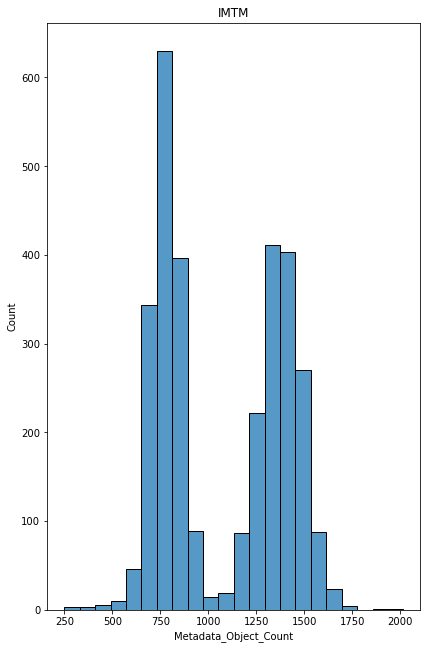

In [19]:
plt.rcParams["figure.figsize"] = (7,10)

fig, (ax1)= plt.subplots(1, sharex=True, sharey=True)
ax1.title.set_text('IMTM')
fig.tight_layout(pad=5.0)
sns.histplot(data=filtered_source_feature_select, x="Metadata_Object_Count", ax = ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumber.pdf',  dpi=300)

In [20]:
# plot cell numbers of controls
filtered_source_feature_select_controls = filtered_source_feature_select[(filtered_source_feature_select["Metadata_RoughID_unique"] == "DMSO") |
                                    (filtered_source_feature_select["Metadata_RoughID_unique"] == "Nocodazole") |
                                    (filtered_source_feature_select["Metadata_RoughID_unique"] == "Tetrandrine") ]

<AxesSubplot: title={'center': 'USC C1162'}, xlabel='Metadata_RoughID_unique', ylabel='Metadata_Object_Count'>

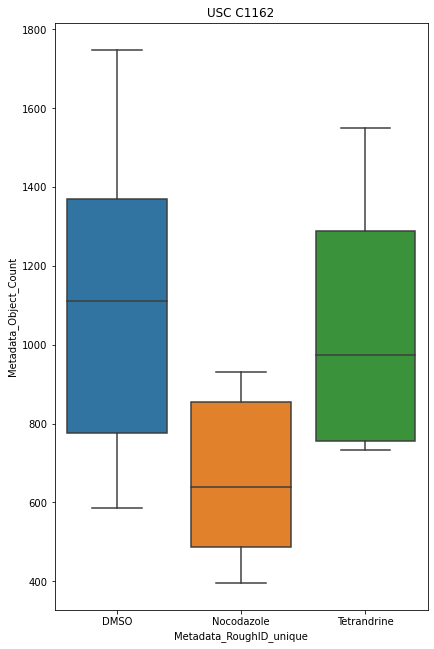

In [21]:
fig, (ax1)= plt.subplots(1, sharex=False, sharey=True)
ax1.title.set_text('USC C1162')
fig.tight_layout(pad=5.0)
sns.boxplot(data=filtered_source_feature_select_controls, y="Metadata_Object_Count", x="Metadata_RoughID_unique", ax=ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumberControls.pdf',  dpi=300)

<AxesSubplot: title={'center': 'USC C1162'}, xlabel='Metadata_Object_Count', ylabel='Count'>

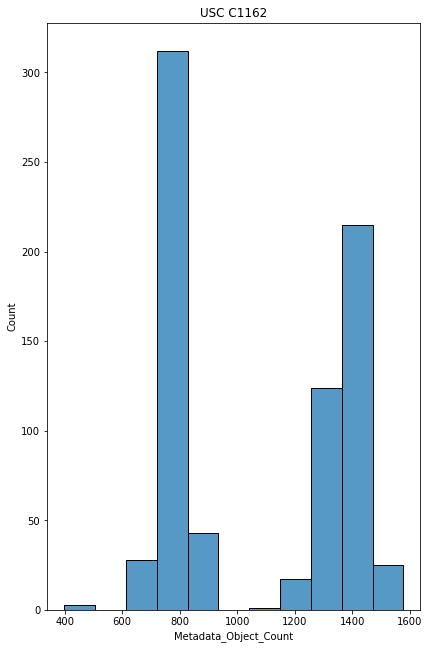

In [22]:
plt.rcParams["figure.figsize"] = (7,10)

fig, (ax1)= plt.subplots(1, sharex=True, sharey=True)
ax1.title.set_text('USC C1162')
fig.tight_layout(pad=5.0)
sns.histplot(data=median_filtered_source_feature_select, x="Metadata_Object_Count", ax = ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumber.pdf',  dpi=300)

<AxesSubplot: title={'center': 'USC C1162'}, xlabel='Metadata_RoughID_unique', ylabel='Metadata_Object_Count'>

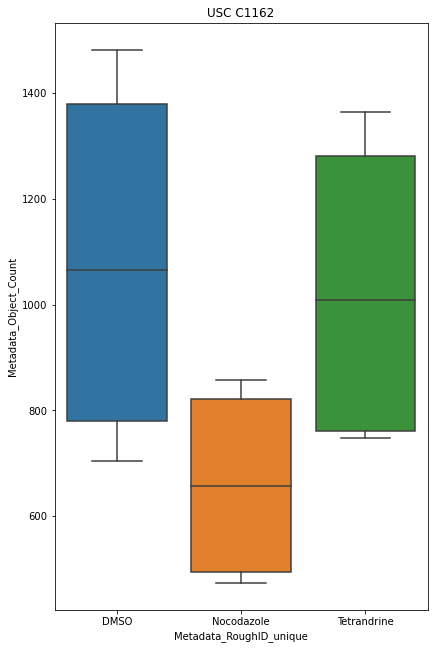

In [23]:
# plot cell numbers of controls
median_filtered_source_feature_select_controls = median_filtered_source_feature_select[(median_filtered_source_feature_select["Metadata_RoughID_unique"] == "DMSO") |
                                                                                                   (median_filtered_source_feature_select["Metadata_RoughID_unique"] == "Tetrandrine") |
                                                                                                   (median_filtered_source_feature_select["Metadata_RoughID_unique"] == "Nocodazole") ]


fig, (ax1)= plt.subplots(1, sharex=False, sharey=True)
ax1.title.set_text('USC C1162')
fig.tight_layout(pad=5.0)
sns.boxplot(data=median_filtered_source_feature_select_controls, y="Metadata_Object_Count", x="Metadata_RoughID_unique", ax=ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumberControls.pdf',  dpi=300)

# Toxicity

In [24]:
missing_compounds = pd.merge(controls_layout, 
                                 filtered_source_feature_select,
                                 on = ["Metadata_RoughID_unique"],
                                 how = "left",
                                 indicator = True)

missing_compounds = missing_compounds[missing_compounds["_merge"] == 'left_only'].dropna(axis='columns')

In [25]:
missing_compounds.head()

,Metadata_Well_x,Metadata_RoughID_x,Metadata_RoughID_unique,index,Metadata_Well_y,Metadata_instrument,Metadata_imaging_time,Metadata_source,Metadata_imaging_timezone,Metadata_Batch,...,Cyto_Texture_SumAverage_DNA_10_03_256,Cyto_Texture_SumAverage_DNA_3_01_256,Cyto_Texture_SumAverage_DNA_5_02_256,Cyto_Texture_SumEntropy_DNA_3_03_256,Cyto_Texture_SumEntropy_DNA_5_00_256,Cyto_Texture_SumEntropy_DNA_5_01_256,Cyto_Texture_SumEntropy_DNA_5_02_256,Cyto_Texture_SumEntropy_DNA_5_03_256,Cyto_Texture_SumVariance_DNA_5_02_256,_merge


In [26]:
## 2.5 Std from population median
# TODO: problematic tox threshold does not work currently
# Now set to 1.5 STDs from sample median
# Works well on larger samples...???
SD_Threshold = 1.5

tox_threshold_1 = median_filtered_source_feature_select["Metadata_Object_Count"].median() - (SD_Threshold * filtered_source_feature_select["Metadata_Object_Count"].std())
print("Tox threshold:", tox_threshold_1)

FMP_Toxic_conditions_1 = filtered_source_feature_select.loc[filtered_source_feature_select["Metadata_Object_Count"] < tox_threshold_1]
print("Toxic conditions: " + str(len(FMP_Toxic_conditions_1 )) + " compounds (" + str(SD_Threshold) + " Std from population median)")

Tox threshold: 422.67881923038954
Toxic conditions: 7 compounds (1.5 Std from population median)


# Raw % replication


In [28]:
replicating_source, corr_replicating_source = CBE.remove_non_reproducible(
    filtered_source_feature_select, 
    n_samples = 5000, 
    n_replicates = 4, 
    ID_col = "Metadata_RoughID_unique", 
    description = "IMTM")


| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| IMTM          |                   2.8 |
Nonreplicating conditions removed with threshold 0.14
Old shape (3072, 815)
New shape (320, 815)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/notebooks/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


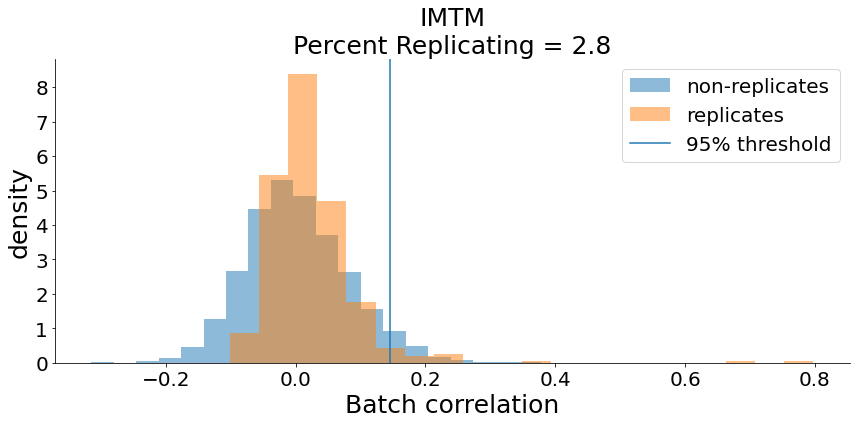

In [29]:

n_experiments = len(corr_replicating_source)

plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_source.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_source.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_source.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_source.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_source.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()

plt.tight_layout()

# plt.savefig(figure_path + str(date.today()) + "_HepG2_Percent_Replicating.pdf", 
#            transparent=False, 
#            bbox_inches='tight', 
#            dpi = 600)

# Compute induction 

In [30]:
# based on consensus profiles
# In the original analysis this is done after removing toxic compounds
# per source and plate, plot over imaging time
# tally up also

# "Metadata_source", 
# "Metadata_RoughID_unique",
# "Metadata_plate_name",
# "Metadata_Well"

In [31]:
## gets feature vector
Features_median_filtered_source_feature_select = CBE.get_feature_vector(median_filtered_source_feature_select)


len(median_filtered_source_feature_select["Metadata_RoughID_unique"].unique())

355

In [32]:
def remove_non_active(df: pd.DataFrame, 
                      key_col, 
                      feature_activity_threshold=3.0, 
                      induction_threshold=5):
    """
    removes compounds via induction threshold
    :param df: consensus, feature selected CellProfiler Profiles
    :param key_col = ["Metadata_EOS", "Metadata_Plate", "Metadata_Concentration"]
    :param feature_activity_threshold: z-score where feature is considered active
    :param induction_threshold: % of active features where compound passes threshold
    :return: new DataFrame with active compounds, new DataFrame with non active compounds
    """
    # removes key columns
    feature_df = df.drop(columns=key_col)
 
    # percent of features equal or higher than activity threshold
    induction = (feature_df >= feature_activity_threshold).sum(axis=1) / len(feature_df.columns) * 100

    # treatments with induction equal or higher than induction threshold
    Data_active = df[(induction >= induction_threshold)]
    
    # treatments with induction lower than induction threshold
    Data_non_active = df[(induction < induction_threshold)]
    
    return Data_active, Data_non_active

In [33]:
key_col = ["Metadata_source", "Metadata_RoughID_unique", "Metadata_plate_name", "Metadata_Well"]

active, non_active = remove_non_active(median_filtered_source_feature_select, 
                                                   key_col,
                                                   3.0, 
                                                   5.0)

print("Active:", len(active["Metadata_RoughID_unique"].unique()))
print("Non-active:", len(non_active["Metadata_RoughID_unique"].unique()))

Active: 10
Non-active: 353


In [34]:
non_active_EOS = pd.DataFrame(non_active["Metadata_RoughID_unique"].unique(), columns = ["Metadata_RoughID_unique"])

In [35]:
Reduced_active = filtered_source_feature_select[
    (filtered_source_feature_select['Metadata_RoughID_unique'].isin(active['Metadata_RoughID_unique']))]

# Compute metrics over replicates

In [36]:
# % replication over plates per source, per plate, plot over imaging time

In [37]:
active_replicating, active_corr_replicating_df = CBE.remove_non_reproducible(
    Reduced_active, 
    n_samples = 5000, 
    n_replicates = 4, 
    ID_col = "Metadata_Well", 
    description = "Data_50")

| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| Data_50       |                  33.3 |
Nonreplicating conditions removed with threshold 0.27
Old shape (96, 815)
New shape (32, 815)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/notebooks/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


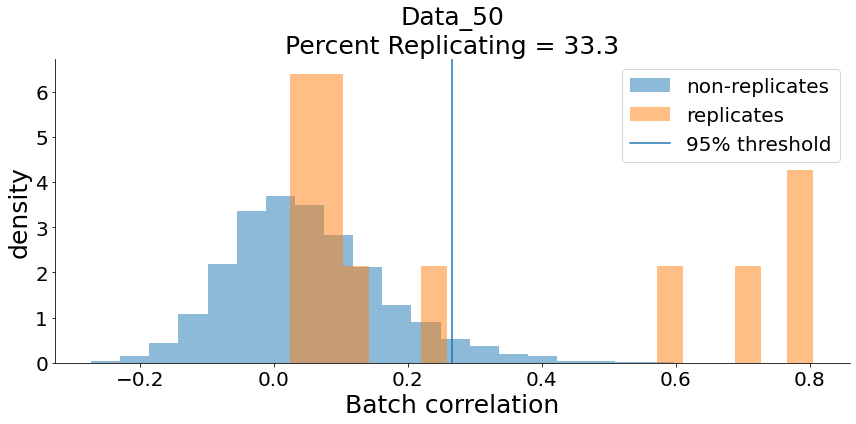

In [38]:
# plot % replicating
corr_replicating_df = active_corr_replicating_df

n_experiments = len(corr_replicating_df)


plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_df.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_df.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_df.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()

# plt.savefig(figure_path + str(date.today()) + "_HepG2_Percent_Replicating_Induction_Filter.pdf", 
            #transparent=False, 
            #bbox_inches='tight', 
            #dpi = 600)# 

In [39]:
# Threshold computation does not work with smaller sample size
# Compare with bioactives data. Suspect this is the case there too.

In [40]:
# TODO: If all replicates exist:
# TODO: Feature reduction per plate
# TODO: Compute number of toxic compounds
# TODO: Compute raw % replication
# TODO: Compute compound activity based on DMSO
# TODO: Compute % replication after compound filters

In [ ]:
# TODO: Over entire dataset that has all replicates available